# Electrophysiology example
How to insert electrodes and measure different spiking and extracellular signals

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from brian2 import *
import cleosim
from cleosim import *
# the default cython compilation target isn't worth it for 
# this trivial example
prefs.codegen.target = "numpy"

First we create an example network:

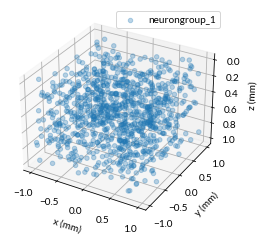

In [19]:
n = 1000
ng = NeuronGroup(
    1000,
    """dv/dt = (-v - 70*mV) / tau : volt
    tau = 10*ms : second""",
    threshold="v>-50*mV",
    reset="v=-70*mV"
)
input_group = PoissonGroup(n, np.linspace(0, 100, n)*Hz + 10*Hz)

S = Synapses(input_group, ng, on_pre='v+=5*mV')
S.connect(condition='abs(i-j)<=3')

net = Network([ng, input_group, S])

cleosim.coordinates.assign_coords_rand_rect_prism(ng, (-1, 1), (-1, 1), (0, 1))
cleosim.coordinates.plot_neuron_positions(ng)

Now we insert an electrode shank probe in the center of the population by injecting an `ElectrodeGroup` device.
Note that `ElectrodeGroup` takes arbitrary coordinates as arguments, so you can place contacts wherever you wish.

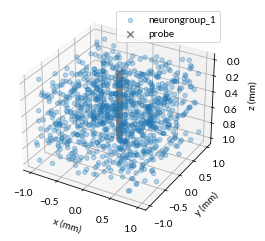

In [20]:
coords = cleosim.ephys.get_1D_probe_coords(0.8*mm, 32)
eg = cleosim.ephys.ElectrodeGroup("probe", coords)
cleosim.coordinates.plot_neuron_positions(ng, devices_to_plot=[eg])

This looks right, but we need to specify what signals we want to pick up with our electrode.

In [ ]:
# spiking = cleosim.ephys.Spiking